<a href="https://colab.research.google.com/github/aisha13dikko-sudo/AISD-poverty-Kaduna/blob/master/Nigeria_tabular_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [5]:
# Load Nigeria LSMS data
cons = pd.read_csv("totcons_final.csv")
hh   = pd.read_csv("nga_householdgeovars_y4.csv")

print(cons.columns)
print(hh.columns)



Index(['hhid', 'zone', 'sector', 'ea', 'hhsize', 'wt_wave4', 'popw',
       'food_own1', 'food_purch1', 'food_own2', 'food_purch2', 'food_own3',
       'food_purch3', 'food_own4', 'food_purch4', 'food_own5', 'food_purch5',
       'food_own6', 'food_purch6', 'food_own7', 'food_purch7', 'food_own8',
       'food_purch8', 'food_own9', 'food_purch9', 'food_own10', 'food_purch10',
       'food_own11', 'food_purch11', 'food_own12', 'food_purch12',
       'food_own13', 'food_purch13', 'food_own14', 'food_purch14',
       'food_own15', 'food_purch15', 'food_own16', 'food_purch16',
       'food_own17', 'food_purch17', 'food_own18', 'food_purch18',
       'food_own19', 'food_purch19', 'food_meals20', 'nonfood21', 'nonfood22',
       'nonfood23', 'nonfood24', 'nonfood25', 'nonfood26', 'nonfood27',
       'nonfood28', 'nonfood29', 'edu29', 'edu30', 'health31', 'health32',
       'rent33', 'reg_def_mean', 'totcons_pc', 'totcons_adj',
       'totcons_adj_norm'],
      dtype='object')
Index(['hhid', 

In [6]:

df = cons.merge(hh, on="hhid", how="inner")
print(df.shape)
df.head()


(4976, 100)


,hhid,zone,sector,ea,hhsize,wt_wave4,popw,food_own1,food_purch1,food_own2,...,h2018_tot,h2018_wetQ,h2018_wetQstart,qstartavg,ndvi_avg,ndvi_max,h2018_ndvi_avg,h2018_ndvi_max,lat_dd_mod,lon_dd_mod
0,10001,4,1,670,6,15279.640625,91677.843750,0.0,3041.666667,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536
1,10002,4,1,670,5,15279.640625,76398.203125,0.0,4171.428516,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536
2,10003,4,1,670,6,15279.640625,91677.843750,0.0,3804.035807,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536
3,10004,4,1,670,4,15279.640625,61118.562500,0.0,9125.000000,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536
4,10005,4,1,670,6,15279.640625,91677.843750,0.0,0.000000,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536


In [7]:
import numpy as np

print(df.shape)
print(df.columns[:15])

(4976, 100)
Index(['hhid', 'zone', 'sector', 'ea', 'hhsize', 'wt_wave4', 'popw',
       'food_own1', 'food_purch1', 'food_own2', 'food_purch2', 'food_own3',
       'food_purch3', 'food_own4', 'food_purch4'],
      dtype='object')


In [8]:
# 1) Choose target column
target_col = "totcons_adj"

# 2) Drop rows where target is missing
df_model = df.dropna(subset=[target_col]).copy()

# 3) Log-transform target to reduce skewness
y = np.log1p(df_model[target_col].astype(float))

# 4) Define which columns to EXCLUDE from features
cols_to_exclude = [
    "hhid",
    "totcons_pc",
    "totcons_adj",
    "totcons_adj_norm",
    "lat_dd_mod",
    "lon_dd_mod",
]

# 5) Candidate feature columns = all others
feature_candidates = [c for c in df_model.columns if c not in cols_to_exclude]

# 6) Keep only numeric feature columns
X = df_model[feature_candidates].select_dtypes(include=[np.number])

# 7) Simple missing-value handling
X = X.fillna(0)

X.shape, y.shape


((4976, 94), (4976,))

In [9]:
# Train/validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape



((3980, 94), (996, 94))

In [10]:
# Pytorch tensors
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [11]:
# Data loaders
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

X_val_t   = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)


In [12]:
# Define MLP model
input_dim = X_train.shape[1]
input_dim


94

In [13]:
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [14]:
# Train the model
num_epochs = 25
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_train = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * xb.size(0)

    train_loss = running_train / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            running_val += loss.item() * xb.size(0)

    val_loss = running_val / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}  Train={train_loss:.4f}  Val={val_loss:.4f}")


Epoch 1/25  Train=458632.3487  Val=28981.2078
Epoch 2/25  Train=712281.2013  Val=32818.4216
Epoch 3/25  Train=1652198.2005  Val=141833.7504
Epoch 4/25  Train=75622.3796  Val=4773.8150
Epoch 5/25  Train=261617.5465  Val=23470.9613
Epoch 6/25  Train=287813.3011  Val=2094.8031
Epoch 7/25  Train=32183.4866  Val=401.2770
Epoch 8/25  Train=23748.9457  Val=695.0862
Epoch 9/25  Train=11126.7621  Val=362.0917
Epoch 10/25  Train=94191.5128  Val=173.6996
Epoch 11/25  Train=21039.6671  Val=129.9247
Epoch 12/25  Train=2410.7698  Val=130.4993
Epoch 13/25  Train=1977.6703  Val=132.3189
Epoch 14/25  Train=10460.4377  Val=125.9359
Epoch 15/25  Train=9464.9416  Val=135.3705
Epoch 16/25  Train=808.5037  Val=136.3156
Epoch 17/25  Train=12609.4576  Val=150.0183
Epoch 18/25  Train=5445.9961  Val=143.3143
Epoch 19/25  Train=1667.9448  Val=144.2287
Epoch 20/25  Train=1580.0669  Val=142.0735
Epoch 21/25  Train=548.2822  Val=141.5030
Epoch 22/25  Train=545.2661  Val=141.3617
Epoch 23/25  Train=2641.9659  Val=14

In [15]:
# Evaluate performance
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_t).cpu().numpy().flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)


MSE: 140.3308656923246
RMSE: 11.846132942539713
MAE: 11.793005632807114
R2: -307.14614520941024


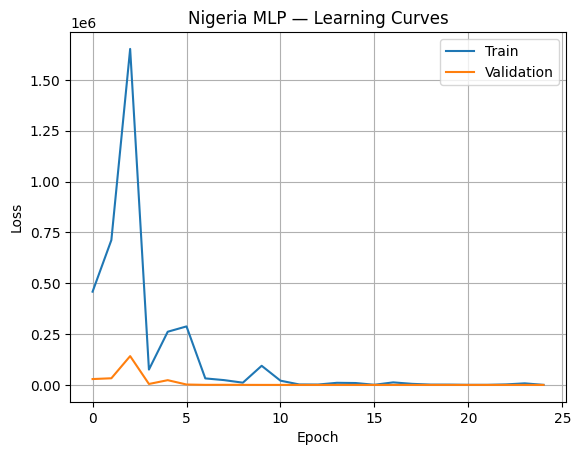

In [16]:
# plot learning curves
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Nigeria MLP — Learning Curves")
plt.legend()
plt.grid(True)
plt.savefig("nigeria_mlp_learning_curve.png", dpi=300, bbox_inches="tight")
plt.show()


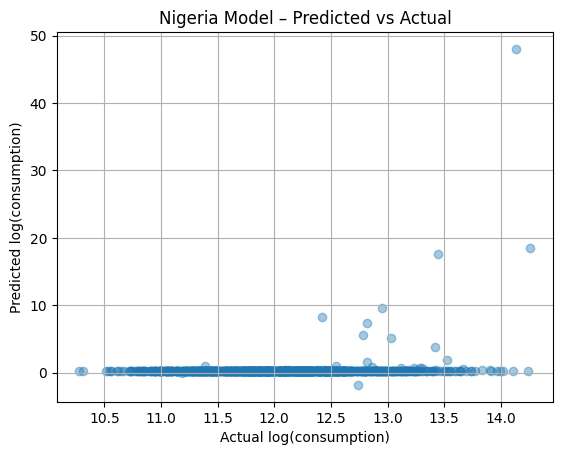

In [17]:
# plot Predicted vs Actual
plt.scatter(y_val, y_val_pred, alpha=0.4)
plt.xlabel("Actual log(consumption)")
plt.ylabel("Predicted log(consumption)")
plt.title("Nigeria Model – Predicted vs Actual")
plt.grid(True)
plt.savefig("nigeria_pred_vs_actual.png", dpi=300, bbox_inches="tight")
plt.show()
